In [5]:
import xarray as xr
import numpy as np
import sys
from pathlib import Path
import pandas as pd
import geopandas as gpd
from scipy.stats import gamma, norm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import fisk, norm


# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))

# Configuration

In [6]:
# Configuration
config = {
    'input_data_dir': project_root / 'data' / 'output_data' / 'merged_2d'/'1980_2024'/'SPEI'/'bow_combined_SPEI_data.csv',
    'shapefile_dir': project_root / 'data' / 'input_data' / 'shapefiles'/'BowRiverBasin'/'Bow_elevation_combined.shp',
    'merged_output_dir': project_root / 'data' / 'output_data' / 'merged_2d'/'1980_2024'/'SPEI',
    'plots': project_root / 'data' / 'output_plots' / '1980_2024'/'SPEI',
}

Open data for analysis

In [7]:
# Open shape file
bow_basin = gpd.read_file(config['shapefile_dir'])
display(bow_basin)

,PROVCD_1,VALDATE,EDITION,DATASETNAM,VERSION,COMPLEVEL,WSCMDA,WSCSDA,WSCSSDA,FDA,...,WSCSSDANAM,min,max,mean,count,std,median,PROVCD_2,elev_class,geometry
0,AB,20070208,1,05BM000,0,NHN-CL1,05,05B,05BM,05BM,...,Lower Bow - Crowfoot,776.0,1177.0,953.688214,9897452,71.132927,944.0,None,500_1000m,"POLYGON ((-112.58577 51.23024, -112.58519 51.2..."
1,AB,20070130,1,05BN000,0,NHN-CL1,05,05B,05BN,05BN,...,Lower Bow - Mouth,700.0,998.0,772.376015,9312616,32.852467,764.0,None,500_1000m,"POLYGON ((-112.4962 50.71881, -112.49566 50.71..."
2,AB,20070226,1,05BH000,0,NHN-CL1,05,05B,05BH,05BH,...,Central Bow - Jumpingpond,1038.0,2479.0,1259.913722,4121228,176.434021,1227.0,None,1000_1500m,"POLYGON ((-113.93263 51.12563, -113.93288 51.1..."
3,AB,20070228,1,05BK000,0,NHN-CL1,05,05B,05BK,05BK,...,Fish (Alta.),981.0,1777.0,1226.170423,1151005,126.086335,1194.0,None,1000_1500m,"POLYGON ((-114.10188 50.95504, -114.0975 50.95..."
4,AB,20070302,1,05BE000,0,NHN-CL1,05,05B,05BE,05BE,...,Upper Bow - Policeman,1146.0,3054.0,1601.837836,1655101,376.052387,1437.0,None,1500_2000m,"POLYGON ((-114.72215 51.33033, -114.72235 51.3..."
5,AB,20070228,1,05BG000,0,NHN-CL1,05,05B,05BG,05BG,...,Ghost,1196.0,3096.0,1782.911133,1683021,373.589221,1639.0,None,1500_2000m,"POLYGON ((-115.085 51.44067, -115.08489 51.440..."
6,AB,20070227,1,05BJ000,0,NHN-CL1,05,05B,05BJ,05BJ,...,Elbow,1052.0,3159.0,1675.498185,2174119,449.060001,1632.0,None,1500_2000m,"POLYGON ((-114.05132 50.99912, -114.05104 50.9..."
7,AB,20100901,2,05BL000,1,NHN-CL1,05,05B,05BL,05BL,...,Highwood,949.0,3126.0,1537.674256,6969452,384.815587,1423.0,BC,1500_2000m,"POLYGON ((-115.01619 50.58248, -115.01545 50.5..."
8,AB,20070319,1,05BA000,0,NHN-CL1,05,05B,05BA,05BA,...,Headwaters Bow,1440.0,3490.0,2163.807362,2635914,373.930172,2182.0,None,2000_2500m,"POLYGON ((-116.25388 51.71161, -116.25374 51.7..."
9,AB,20070315,1,05BB000,0,NHN-CL1,05,05B,05BB,05BB,...,Upper Bow - Redearth,0.0,3296.0,2076.477015,1325557,359.670055,2122.0,None,2000_2500m,"POLYGON ((-115.4726 51.16677, -115.47276 51.16..."


In [8]:
# print column names
print(bow_basin.columns)

Index(['PROVCD_1', 'VALDATE', 'EDITION', 'DATASETNAM', 'VERSION', 'COMPLEVEL',
       'WSCMDA', 'WSCSDA', 'WSCSSDA', 'FDA', 'OCEAN', 'WSCMDANAME',
       'WSCSDANAME', 'WSCSSDANAM', 'min', 'max', 'mean', 'count', 'std',
       'median', 'PROVCD_2', 'elev_class', 'geometry'],
      dtype='object')


In [9]:
SPEI_data = pd.read_csv(config['input_data_dir'])
SPEI_data.set_index('time', inplace=True)

display(SPEI_data.head())

,Grid_id,lon,lat,Precipitation,Mean_Temp,Humidity,Flux,Surface_Pressure,Vwind,Uwind,Elevation,Elevation_Category
time,,,,,,,,,,,,
1980-10-10,1,-116.1380,51.3346,0.009879,-3.783902,0.002236,3049.015615,792.259058,0.311295,-0.084560,213.40561,2000_2500m
1982-07-19,1,-116.1380,51.3346,2.765854,8.561398,0.007391,4451.734360,781.952682,0.568268,1.897212,213.40561,2000_2500m
1983-10-12,2,-116.1875,51.4191,0.023846,-3.537311,0.002839,3352.359415,793.773767,-0.336093,-0.022384,211.10257,2000_2500m
1980-12-11,2,-116.1875,51.4191,4.578907,-7.179487,0.002436,472.984375,778.646749,0.921281,2.757770,211.10257,2000_2500m
1981-07-21,2,-116.1875,51.4191,5.400473,9.413436,0.008504,4196.250000,789.834761,0.053097,0.938094,211.10257,2000_2500m


In [10]:
# Convert index to datetime if not already
SPEI_data.index = pd.to_datetime(SPEI_data.index)

# add season year column
def get_season_year(date):
    if date.month >= 10:
        return date.year 
    else:
        return date.year-1
SPEI_data['season_year'] = SPEI_data.index.to_series().apply(get_season_year)


display(SPEI_data)


,Grid_id,lon,lat,Precipitation,Mean_Temp,Humidity,Flux,Surface_Pressure,Vwind,Uwind,Elevation,Elevation_Category,season_year
time,,,,,,,,,,,,,
1980-10-10,1,-116.1380,51.3346,0.009879,-3.783902,0.002236,3049.015615,792.259058,0.311295,-0.084560,213.40561,2000_2500m,1980
1982-07-19,1,-116.1380,51.3346,2.765854,8.561398,0.007391,4451.734360,781.952682,0.568268,1.897212,213.40561,2000_2500m,1981
1983-10-12,2,-116.1875,51.4191,0.023846,-3.537311,0.002839,3352.359415,793.773767,-0.336093,-0.022384,211.10257,2000_2500m,1983
1980-12-11,2,-116.1875,51.4191,4.578907,-7.179487,0.002436,472.984375,778.646749,0.921281,2.757770,211.10257,2000_2500m,1980
1981-07-21,2,-116.1875,51.4191,5.400473,9.413436,0.008504,4196.250000,789.834761,0.053097,0.938094,211.10257,2000_2500m,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30,257,-111.6202,50.0960,0.000000,15.247152,0.008553,3613.687510,929.798841,4.774907,-1.391672,75.06684,500_1000m,2023
2024-08-31,257,-111.6202,50.0960,0.000000,19.067508,0.006991,5928.843750,934.272581,-0.586701,-0.703945,75.06684,500_1000m,2023
2024-09-28,257,-111.6202,50.0960,0.076506,13.851637,0.004967,3925.062475,930.470793,-0.118627,1.097730,75.06684,500_1000m,2023


# Calculated PET - Thornthwaite method

In [11]:
def thornthwaite_pet(T_monthly, lat, eps=1e-12):
    """
    Thornthwaite PET in mm/month.

    T_monthly: xarray DataArray [time, y, x] monthly mean temperature (°C)
    lat:       xarray DataArray [y, x] latitude (degrees)
    """

    # Ensure temperature > 0°C only (Thornthwaite convention)
    T_pos = T_monthly.where(T_monthly > 0, 0.0)

    # Days per month (time)
    days_in_month = T_monthly["time"].dt.days_in_month

    # Monthly heat index i_m
    i_m = (T_pos / 5.0) ** 1.514

    # Annual heat index I (per year) [y, x]
    I = i_m.groupby("time.year").sum("time")

    # Thornthwaite exponent a(I) [y, x]
    a = (6.75e-7 * I**3
         - 7.71e-5 * I**2
         + 1.792e-2 * I
         + 0.49239)

    # Broadcast I and a back to monthly [time, y, x]
    year = T_monthly["time"].dt.year
    I_m = I.sel(year=year).drop("year")
    a_m = a.sel(year=year).drop("year")

    # Avoid divide-by-zero / nonsense when I ~ 0
    I_m = I_m.where(I_m > eps)

    # Latitude in radians, broadcast to [time, y, x]
    phi = np.deg2rad(lat).broadcast_like(T_monthly)

    # Use mid-month day-of-year for each timestamp
    # (works well for monthly series)
    month = T_monthly["time"].dt.month
    year_num = T_monthly["time"].dt.year
    mid_dates = xr.DataArray(
        np.array([np.datetime64(f"{int(y)}-{int(m):02d}-15") for y, m in zip(year_num.values, month.values)]),
        dims=["time"],
        coords={"time": T_monthly["time"]}
    )
    J = mid_dates.dt.dayofyear
   
    # Solar declination (radians)
    delta = 0.409 * np.sin(2 * np.pi * J / 365.0 - 1.39)
    delta = delta.broadcast_like(T_monthly)

    # Sunset hour angle
    omega_s = np.arccos((-np.tan(phi) * np.tan(delta)).clip(min=-1, max=1))

    # Mean day length (hours)
    L = (24.0 / np.pi) * omega_s

    # Thornthwaite PET (mm/month)
    PET = 16.0 * (L / 12.0) * (days_in_month / 30.0) * ((10.0 * T_pos / I_m) ** a_m)

    # Ensure PET=0 when T<=0
    PET = PET.where(T_monthly > 0, 0.0)

    PET.name = "PET_thornthwaite"
    return PET

In [12]:
# Calculate monthly mean temperature for each grid point (per Grid_id) as an xarray DataArray
temp_wide = SPEI_data.reset_index().set_index(['time', 'Grid_id'])['Mean_Temp'].unstack('Grid_id')

T_da = xr.DataArray(
	temp_wide.to_numpy(),
	dims=['time', 'Grid_id'],
	coords={'time': temp_wide.index, 'Grid_id': temp_wide.columns},
	name='Mean_Temp'
)

# Monthly mean over each calendar month
T_monthly = T_da.resample(time='1M').mean()
T_monthly.name = 'Mean_Temp_monthly'

# Get latitude per Grid_id as an xarray DataArray aligned to the temperature grid
lat_series = SPEI_data[['Grid_id', 'lat']].drop_duplicates('Grid_id').set_index('Grid_id')['lat']
lat = xr.DataArray(lat_series, dims=['Grid_id'], coords={'Grid_id': lat_series.index}, name='lat')

pet_th = thornthwaite_pet(T_monthly, lat,eps=1e-12)
pet_th.name = 'PET'

# keep precipitation , season_year, Elevation_Category columns from SPEI_data



pet_th = pet_th.to_dataframe().reset_index()

display(pet_th)

c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\.venv\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_31132\4065319047.py:29: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  I_m = I.sel(year=year).drop("year")
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_31132\4065319047.py:30: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  a_m = a.sel(year=year).drop("year")


,time,Grid_id,PET
0,1980-01-31,1,0.0
1,1980-01-31,2,0.0
2,1980-01-31,3,0.0
3,1980-01-31,4,0.0
4,1980-01-31,5,0.0
...,...,...,...
138775,2024-12-31,253,0.0
138776,2024-12-31,254,0.0
138777,2024-12-31,255,0.0
138778,2024-12-31,256,0.0


In [13]:
# Calculate monthly precipitation for each season year and grid point
monthly_precip = (
    SPEI_data
    .groupby(['Grid_id', 'season_year','Elevation_Category', pd.Grouper(freq='M')])['Precipitation']
    .sum()
    .reset_index()
)


display(monthly_precip)

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_31132\2271054864.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(['Grid_id', 'season_year','Elevation_Category', pd.Grouper(freq='M')])['Precipitation']


,Grid_id,season_year,Elevation_Category,time,Precipitation
0,1,1979,2000_2500m,1980-01-31,36.775476
1,1,1979,2000_2500m,1980-02-29,22.427567
2,1,1979,2000_2500m,1980-03-31,40.851821
3,1,1979,2000_2500m,1980-04-30,10.105498
4,1,1979,2000_2500m,1980-05-31,129.108904
...,...,...,...,...,...
138775,257,2023,500_1000m,2024-08-31,32.310772
138776,257,2023,500_1000m,2024-09-30,69.917607
138777,257,2024,500_1000m,2024-10-31,9.685615
138778,257,2024,500_1000m,2024-11-30,21.551023


In [14]:
# combine PET and precipitation dataframes
SPEI_combined = pet_th.merge(monthly_precip, on=['time', 'Grid_id'], how='inner')
display(SPEI_combined)

,time,Grid_id,PET,season_year,Elevation_Category,Precipitation
0,1980-01-31,1,0.0,1979,2000_2500m,36.775476
1,1980-01-31,2,0.0,1979,2000_2500m,40.344780
2,1980-01-31,3,0.0,1979,2000_2500m,38.241150
3,1980-01-31,4,0.0,1979,2000_2500m,24.373464
4,1980-01-31,5,0.0,1979,2000_2500m,25.983063
...,...,...,...,...,...,...
138775,2024-12-31,253,0.0,2024,500_1000m,11.981631
138776,2024-12-31,254,0.0,2024,500_1000m,10.429109
138777,2024-12-31,255,0.0,2024,500_1000m,11.572954
138778,2024-12-31,256,0.0,2024,500_1000m,13.378943


In [15]:
# Calculate water balance D = P - PET
SPEI_combined['D'] = SPEI_combined['Precipitation'] - SPEI_combined['PET']

display(SPEI_combined)

,time,Grid_id,PET,season_year,Elevation_Category,Precipitation,D
0,1980-01-31,1,0.0,1979,2000_2500m,36.775476,36.775476
1,1980-01-31,2,0.0,1979,2000_2500m,40.344780,40.344780
2,1980-01-31,3,0.0,1979,2000_2500m,38.241150,38.241150
3,1980-01-31,4,0.0,1979,2000_2500m,24.373464,24.373464
4,1980-01-31,5,0.0,1979,2000_2500m,25.983063,25.983063
...,...,...,...,...,...,...,...
138775,2024-12-31,253,0.0,2024,500_1000m,11.981631,11.981631
138776,2024-12-31,254,0.0,2024,500_1000m,10.429109,10.429109
138777,2024-12-31,255,0.0,2024,500_1000m,11.572954,11.572954
138778,2024-12-31,256,0.0,2024,500_1000m,13.378943,13.378943


In [16]:
# Calculate monthly average precipitation for each Elevation_Category, season_year, and month
SPEI_combined['month'] = SPEI_combined['time'].dt.month

monthly_avg = (
    SPEI_combined
    .groupby(['Elevation_Category', 'season_year', 'month'])['D']
    .mean()
    .unstack(level=0)  # Elevation_Category as columns
)

# Rename columns to match the format "2000-2500m_P"
monthly_avg.columns = [f"{col}_D" for col in monthly_avg.columns]

#drop seasonYear 1979 and 2024
monthly_avg = monthly_avg[(monthly_avg.index.get_level_values('season_year') != 1979) & (monthly_avg.index.get_level_values('season_year') != 2024)]  

# Keep oct to May only
monthly_avg = monthly_avg[monthly_avg.index.get_level_values('month').isin([10,11,12,1,2,3,4,5])]

display(monthly_avg.head(10))

1000_1500m_D  1500_2000m_D  2000_2500m_D  500_1000m_D
season_year month                                                       
1980        1          6.245697      9.145041     11.316449     8.226255
            2          8.437483     13.018755     29.459216     4.767321
            3         11.376336      8.789574     14.930461    21.759639
            4        -23.510222     -5.270348     29.169188   -34.223973
            5         62.318338    101.269334     55.813259    12.875691
            10       -12.530076      1.554117     16.663616    -0.609985
            11        20.709962     32.084248     52.304052    11.935628
            12        24.672522     39.349471     94.355993    27.466716
1981        1         13.760274     15.885581     43.015503    18.841189
            2          9.288835     13.259168     39.124096    11.693719

In [17]:
# Group by season and sum the precipitation for each column
seasonal_D = monthly_avg.groupby('season_year').sum(numeric_only=True)

display(seasonal_D)

,1000_1500m_D,1500_2000m_D,2000_2500m_D,500_1000m_D
season_year,,,,
1980,97.720039,199.940192,304.012235,52.197293
1981,79.098256,127.315757,276.358793,62.187293
1982,34.074932,114.686235,208.455037,-1.226322
1983,17.485114,108.422413,248.425442,-20.710515
1984,-8.870059,90.710383,202.482485,17.497869
1985,43.114590,128.910328,293.794573,-10.203396
1986,-58.561506,24.923621,207.392039,-71.264426
1987,-70.167759,28.882775,220.376994,-102.114027
1988,34.032916,118.795049,248.599283,1.477401


# Calculate SPEI

In [18]:
# Calculate SPEI

def calculate_spei_loglogistic(D_series, eps=1e-12):
    """
    SPEI using 3-parameter log-logistic (Fisk) distribution.
    D_series: pandas Series of D = P - PET (can be negative)
    Returns: pandas Series of SPEI (standard normal)
    """
    s = pd.Series(D_series).astype(float)

    # keep finite values only for fitting
    fit_data = s[np.isfinite(s.values)]
    if fit_data.size < 5 or np.nanstd(fit_data.values) == 0:
        return pd.Series(np.nan, index=s.index)

    # Fit 3-parameter log-logistic (shape=c, loc, scale)
    c, loc, scale = fisk.fit(fit_data.values)

    # CDF for all values (including negatives)
    cdf = fisk.cdf(s.values, c, loc=loc, scale=scale)

    # Avoid inf from norm.ppf at 0 or 1
    cdf = np.clip(cdf, eps, 1 - eps)

    spei = norm.ppf(cdf)
    return pd.Series(spei, index=s.index)

spei_results = {}
for col in seasonal_D.columns:
    spei_results[col.replace('_D', '_SPEI')] = calculate_spei_loglogistic(seasonal_D[col])

spei_df = pd.DataFrame(spei_results, index=seasonal_D.index)
display(spei_df)



,1000_1500m_SPEI,1500_2000m_SPEI,2000_2500m_SPEI,500_1000m_SPEI
season_year,,,,
1980,0.853160,0.554857,0.316050,0.961363
1981,0.831658,-0.509935,-0.103297,0.973506
1982,0.765410,-0.688680,-1.256945,0.878204
1983,0.733115,-0.775368,-0.565205,0.835632
1984,0.665872,-1.012479,-1.360997,0.911703
1985,0.780834,-0.487030,0.166406,0.859763
1986,0.343659,-1.782618,-1.275467,0.638568
1987,-4.018598,-1.740952,-1.049284,-4.208107
1988,0.765335,-0.631081,-0.562248,0.883424


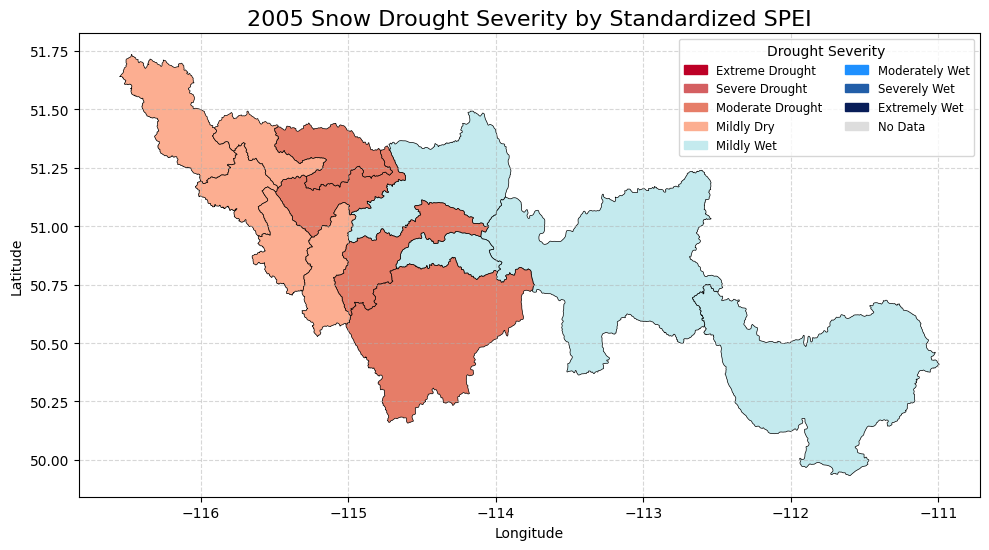

In [25]:
# Define SPEI classification function
def classify_spei(value):
    if value >= 2.0:
        return 'Extremely Wet'
    elif value >= 1.5:
        return 'Severely Wet'
    elif value >= 1.0:
        return 'Moderately Wet'
    elif value >= 0.5:
        return 'Mildly Wet'
    elif value >= -0.5:
        return 'No Data'
    elif value >= -1.0:
        return 'Mildly Dry'
    elif value >= -1.5:
        return 'Moderate Drought'
    elif value >= -2.0:
        return 'Severe Drought'
    else:
        return 'Extreme Drought'

# Create classification columns for each elevation category (only for SPEI columns)
spei_cols = [col for col in spei_df.columns if col.endswith('_SPEI')]
for col in spei_cols:
    class_col = col.replace('_SPEI', '_Classification')
    spei_df[class_col] = spei_df[col].apply(classify_spei)

# Filter onset_to_peak for the year 2005
onset_to_peak_2005 = spei_df[spei_df.index == 2005]

# Get the classification for 2005 from spei_df
classifications_2005 = spei_df[spei_df.index == 2005][[
    '1000_1500m_Classification', '1500_2000m_Classification', '2000_2500m_Classification', '500_1000m_Classification'
]].iloc[0]

# Map elevation category to classification
elev_class_map = {
    '1000_1500m': classifications_2005['1000_1500m_Classification'],
    '1500_2000m': classifications_2005['1500_2000m_Classification'],
    '2000_2500m': classifications_2005['2000_2500m_Classification'],
    '500_1000m': classifications_2005['500_1000m_Classification'],
}
# open Bow Basin shapefile
bow_basin = gpd.read_file(config['shapefile_dir'])

# Add drought classification to the Bow Basin shapefile
bow_basin['Drought_Classification'] = bow_basin['elev_class'].map(elev_class_map)

# Add drought classification to onset_to_peak_2005
onset_to_peak_2005 = onset_to_peak_2005.copy()

# The dataframe already has classification columns, no need to melt or add new classifications
# The classifications are already added to spei_df in the earlier code

# Define a color map for drought severity
severity_colors_SPI = {
    'Extreme Drought': '#BD0026',
    'Severe Drought': '#D45F61',
    'Moderate Drought': '#E67D68',
    'Mildly Dry': '#FCAE91',
    'Mildly Wet': "#C4EAEE",
    'Moderately Wet': '#1E90FF',
    'Severely Wet': '#225EA8',
    'Extremely Wet': '#081D58',
    'No Data': '#dddddd'
}

# Assign colors to each polygon based on drought classification (fill missing with light gray)
bow_basin['color'] = bow_basin['Drought_Classification'].map(severity_colors_SPI).fillna('#dddddd')

# Plot the Bow Basin colored by drought severity
fig, ax = plt.subplots(figsize=(10, 8))
bow_basin.plot(ax=ax, color=bow_basin['color'], edgecolor='black', linewidth=0.5)

# Create a full legend showing all severity categories (even if not present on the map)
legend_order = list(severity_colors_SPI.keys())
legend_patches = [mpatches.Patch(color=severity_colors_SPI[k], label=k) for k in legend_order]

# Place the legend; use multiple columns to keep it compact
plt.legend(handles=legend_patches, title='Drought Severity', loc='upper right',
           bbox_to_anchor=(1.00, 1.00), ncol=2, fontsize='small', frameon=True)

plt.title('2005 Snow Drought Severity by Standardized SPEI', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save to an existing path in config (use 'plots' to avoid missing key)
#outpath = config.get('plots', config.get('output_dir'))
#plt.savefig(Path(outpath) / 'bow_basin_drought_severity_2005.png', dpi=150)
plt.show()